<a href="https://colab.research.google.com/github/tdbartolo/tdbartolo-rep/blob/main/PNL_transformer_dataset_restaurante_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib #pip install dataset instala biblioteca do hugging face

In [2]:
# carregando dados do HF
from datasets import load_dataset
#from sklearn.model_selection import train_test_split

url_test = "https://raw.githubusercontent.com/tdbartolo/tdbartolo-rep/main/test.csv"
url_train = "https://raw.githubusercontent.com/tdbartolo/tdbartolo-rep/main/train.csv"

dataset = load_dataset('csv', data_files={'train': url_train, 'test': url_test}, column_names=['text', 'label', 'Recommends'], skiprows=[0])

dataset = dataset.class_encode_column(column="label") # precisa pro trainer saber qual a coluna precisa aprender a predizer

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 3321
    })
})

In [4]:
dataset["train"] = dataset["train"].remove_columns("Recommends")
dataset["test"] = dataset["test"].remove_columns("Recommends")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3321
    })
})

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Converter o dataset para um DataFrame pandas
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Remover as linhas com valores vazios ou None
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train['label'] = df_train['label'].astype('int64')
df_test['label'] = df_test['label'].astype('int64')

df_train.loc[:, "text"] = df_train["text"].str.encode("ascii", "ignore").str.decode("utf-8")
df_test.loc[:, "text"] = df_test["text"].str.encode("ascii", "ignore").str.decode("utf-8")

# Converter o DataFrame de volta para o formato de Dataset
dataset["train"] = Dataset.from_pandas(df_train)
dataset["test"] = Dataset.from_pandas(df_test)

In [7]:
#verifica quantos labels únicos temos
set(dataset["train"] ["label"])
#dataset["train"]

{0, 1, 2, 3, 4}

In [8]:
dataset["train"] = dataset["train"].remove_columns("__index_level_0__")
dataset["test"] = dataset["test"].remove_columns("__index_level_0__")

In [9]:
#mostra a quantidade de linhas do dataset no treino e  no teste
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11802
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2876
    })
})

In [10]:
# gerando datasets menores para treino, validação e teste (para poupar tempo)
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(100)) # pega de 0 a 999 para o treino
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(1000,1050)) # pega os dados de 1.000 a 1.499 para validação
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(50)) #pega 500 do teste

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# carregando modelo BERT pré-treinado e o tokenizer do modelo pré-treinado

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [12]:
#chama a função tokenized e aplica em cada linha do texto
#método map passa uma função em todo o dataset
#o toquenizador criou input_ids', 'token_type_ids', 'attention_mask'

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
#tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [13]:
tokenized_small_train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})

In [15]:
#visualização do dataset
import pandas as pd

small_train_df = pd.DataFrame(tokenized_small_train_dataset)

small_train_df.head(10)

,text,label,input_ids,token_type_ids,attention_mask
0,Chicken chap and luchi... Awsm taste...with an...,4,"[101, 18770, 22572, 11478, 1105, 181, 16643, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,One of my favourite..I just loved the decorati...,4,"[101, 1448, 1104, 1139, 9122, 119, 119, 146, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"Undoubtedly,one of the best place for pizza,pa...",4,"[101, 12118, 2572, 10354, 1906, 1193, 117, 114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Taste of the foods were phenomenal the steak w...,4,"[101, 27589, 1104, 1103, 11785, 1127, 14343, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Hidden camera in girls washroom. Everyone boyc...,0,"[101, 19595, 4504, 1107, 2636, 10124, 6077, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,", , ? , , ...",1,"[101, 117, 117, 136, 117, 117, 117, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
6,"Average,, not good at all..quantity and qualit...",2,"[101, 18098, 117, 117, 1136, 1363, 1120, 1155,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,It's wallah and delicious... Keep up this fabu...,3,"[101, 1135, 112, 188, 2095, 3354, 1105, 13108,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,osmmmm place & also osmmm food I loved it ...,4,"[101, 184, 6602, 6262, 1306, 1282, 111, 1145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,"Classy & delicious food menu , elegant space t...",4,"[101, 3699, 1183, 111, 13108, 2094, 13171, 117...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [16]:
#ver o dado toquenizado
#tokenized_small_train_dataset [0]


In [17]:
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate #biblioteca para carregar métrica

metric = evaluate.load("accuracy")

#cria uma função para computar a métrica
def compute_metrics(eval_pred): #eval_pred é o que o modelo previu
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) #pega o id que tem maior probabilidade
    return metric.compute(predictions=predictions, references=labels) #compara o ID predito com o label esperado

#onde vai salvar o modelo treinado
MODEL_PATH = "modelo_aula_bert_2"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps", #fazer o evaluation no step de validação a cada 10 steps
    eval_steps=10,
    per_device_train_batch_size=1,#8
    per_device_eval_batch_size=1,#8
    gradient_accumulation_steps=1, #4 gradient_accumulation_steps* per_device_eval_batch_size=batch
    max_steps=10,  # 200 por quantos steps eu quero treinar o modelo
    learning_rate=3e-5, #3e-5
    logging_strategy="steps", #a cada 10 steps vai printar
    logging_steps=10,
    save_steps=50, #salvar check point a cada 50 steps
    load_best_model_at_end=True, #pega o melhor dos que salvou
    metric_for_best_model="accuracy",
    greater_is_better=True, #se for maior é bom pq acurácia é medida de acerto
    save_total_limit=2, #quantos checkpoints vai salvar
    disable_tqdm=False #aparece a barrinha carregando
)
#entra com o modelo definido acima, os argumentos e os datasets, o trainer espera a função que computa a métrica
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

# Nova seção

In [18]:
#treina o modelo
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.441700,1.182132,0.700000


TrainOutput(global_step=10, training_loss=1.4416536331176757, metrics={'train_runtime': 134.3636, 'train_samples_per_second': 0.074, 'train_steps_per_second': 0.074, 'total_flos': 2631181424640.0, 'train_loss': 1.4416536331176757, 'epoch': 0.1})

In [19]:
#verifica se loss está muito ruidoso (sobe e desce) que o learning rate pode estar muito alto ou o dado estar ruim
import pandas as pd

df_log = pd.DataFrame(trainer.state.log_history)
df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.4417,0.0,0.1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.1,10,1.182132,0.7,79.0226,0.633,0.633,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.1,10,NaN,NaN,NaN,NaN,NaN,134.3636,0.074,0.074,2.631181e+12,1.441654


<Axes: >

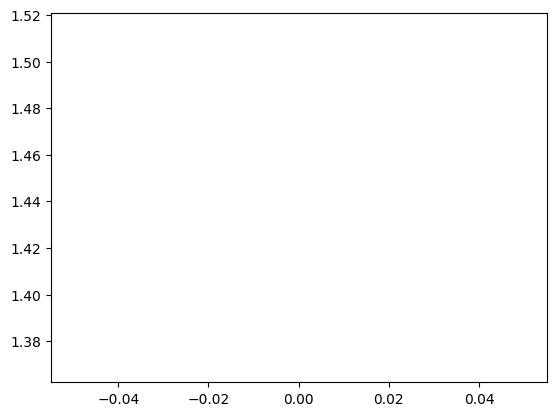

In [20]:
df_log["loss"].dropna().plot()

<Axes: >

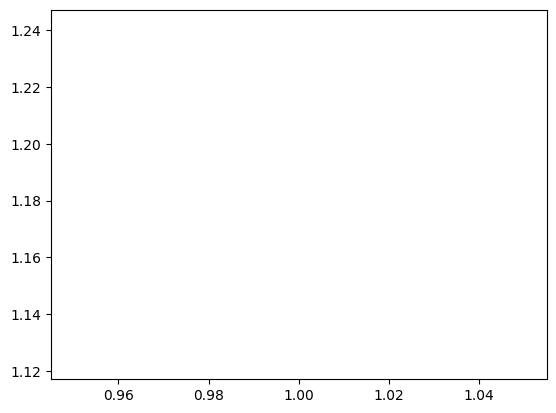

In [21]:
#se o eval_loss desce muito e depois sobe é sinal de overfitting
df_log["eval_loss"].dropna().plot()

<Axes: >

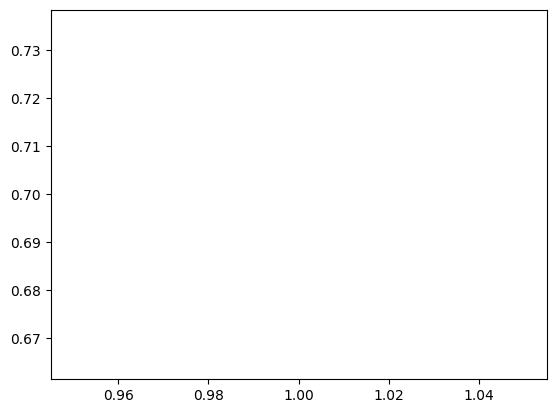

In [22]:
df_log["eval_accuracy"].dropna().plot()

In [24]:
#salva o modelo e o tokenizador
trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('modelo_aula_bert_2/tokenizer_config.json',
 'modelo_aula_bert_2/special_tokens_map.json',
 'modelo_aula_bert_2/vocab.txt',
 'modelo_aula_bert_2/added_tokens.json',
 'modelo_aula_bert_2/tokenizer.json')

In [25]:
import torch.nn.functional as F
import torch
#carrega o nosso modelo que salvamos no ambiente de execução do colab/podemos salvar no computador para não ter que treinar novamente
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [31]:
# Criar uma lista para armazenar as predições
predictions = []
real = []

# Iterar sobre as amostras do dataset
for example in small_test_dataset:
    # Tokenizar o texto
    encoded_input = tokenizer(example["text"], return_tensors="pt")

    # Passar os dados tokenizados pelo modelo
    output = model(**encoded_input)
    probs = torch.softmax(output.logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    #print(probs)
    # Armazenar a predição na lista de predições
    predictions.append(pred)
    real.append(example["label"])

# Imprimir as predições
print(predictions)
print(real)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 0, 4, 3, 4, 0, 1, 4, 4, 4, 4, 1, 4, 3, 0, 0, 4, 4, 4, 4, 4, 4, 0, 3, 4, 1, 2, 4, 4, 4, 4, 4, 3, 3, 4, 0, 4, 0, 1, 0, 4]


Text(50.722222222222214, 0.5, 'Truth')

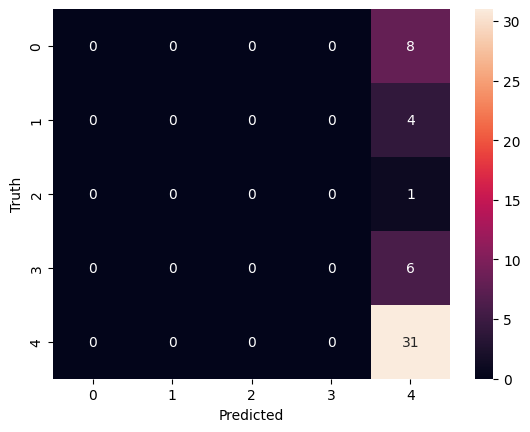

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

cm=confusion_matrix(real,predictions)
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")